In [170]:
import jax.numpy as np
import jax.scipy as sp
import jax
from jax import jit, grad, vmap, value_and_grad
from jax.example_libraries import optimizers
from jax.tree_util import Partial

from tqdm import tqdm, trange

# from tensorflow_probability.substrates import jax as tfp
jax.default_device = jax.devices('cpu')[0]
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [68]:
vmap(lambda x: x.sum())(np.arange(100).reshape(10,10))

Array([ 45, 145, 245, 345, 445, 545, 645, 745, 845, 945], dtype=int32)

In [60]:
def value_and_jacrev(f, x):
    y, pullback = jax.vjp(f, x)
    basis = np.eye(y.size, dtype=y.dtype)
    jac = jax.vmap(pullback)(basis)
    return y, jac

### The Idea

In Bayesian statistics, we search for a posterior distribution of parameters:
$$p(\theta | D) = \frac{p(D | \theta)p(\theta)}{p(D)} \propto p(D | \theta)p(\theta)$$

But, if the parameters represent a function, i.e., they are parameters of the function, maybe what we are looking for is the posterior probability over **functions**:

$$p(f | D) = \frac{p(D | f)p(f)}{p(D)} \propto p(D | f)p(f)$$

$$p(D | f) = p(X, Y | f) = p(Y | X, f)p(X | f) = p(Y | X, f)p(X)$$

$$p(D) = p(X, Y) = p(Y | X)p(X) $$

$$p(f | D) = \frac{p(D | f)p(f)}{p(D)} = \frac{p(Y | X, f)p(X)p(f)}{p(Y | X)p(X)} = \frac{p(Y | X, f)p(f)}{p(Y | X)}$$

$$\mathbb{D}_{KL}[q(f | D) | p(f | D)] = -\mathbb{E}_{f \sim q}\text{log}\frac{p(f|D)}{q(f|D)} = -\mathbb{E}_{f \sim q}\text{log}\frac{p(Y | X, f)p(X | f)p(f)}{q(f|D)} = -\mathbb{E}_{f \sim q}\text{log}p(Y | X, f) - \mathbb{E}_{f \sim q}\text{log}\frac{p(f)}{q(f|D)} + C$$

$$\mathbb{D}_{KL}[q(f | D) | p(f | D)] = -\mathbb{E}_{f \sim q}\text{log}p(Y | X, f) + \mathbb{D}_{KL}[q(f|D) | p(f)] + C $$

$$\mathbb{D}_{KL}[q(f | D) | p(f | D)] = -\mathbb{E}_{f \sim q}\text{log}p(Y | X, f) + \mathbb{H}[q(f|D), p(f)] - \mathbb{H}[q(f|D)] + C $$

The relative enropy $\mathbb{H}[q(f|D), p(f)] = -\mathbb{E}_{f \sim q}\text{log}p(f)$ is simple to calculate, since we can sample from $q$ and we choose our prior. Having a sampler, we can also easily evaluate the first term, the cross-entropy "loss". However, to calculate the second term, the entropy of $q$, we need the surrogate posterior $q$. The trick is to use the derivative of our sampler instead:

$$\text{log}\frac{d}{dp}F^{-1}(p) = \text{log}\frac{1}{F'(F^{-1}(p))} = \text{log}\frac{1}{q(f|D)} = -\text{log}q(f|D)$$
since inverse of cdf $F^{-1}$ is a sampler (!!!) then $F^{-1}=f$ and $F'$ is density function, so $F'=q(\cdot|D)$. Therefore, we can calculate the entropy of $q$ as follows:

$$H(q) = -\mathbb{E}_{f \sim q}\text{log}q(f | D)= -\mathbb{E}_{p \sim U}\text{log}q(F^{-1}(p) | D) = \mathbb{E}_{f \sim q}\text{log}\frac{d}{dp}F^{-1}(p)$$

where the $F^{-1}: p \rightarrow (\mathcal{X} \rightarrow \mathcal{Y}) $ returns a neural network, $\mathcal{X}$ is input space, $\mathcal{Y}$ is the output space, $F^{-1}(p) = f$ and $p \sim U$ is the source of randomness.

Niestety to pewnie nie działa, bo rzeczywiście $F^{-1}$ jest samplerem z dystrybucji, ale nie każdy sampler jest odwrotnością cdf. Ale będziemy próbować.


Let the inner product of two functions on $X \sim \mathcal{X}$ be:
$$\langle f(X),\;g(X)\rangle \triangleq \mathbb{E}_{X \sim \mathcal{X}}(f(X)g(X))$$
Now, we form a norm: 
$$||f|| \triangleq \sqrt{\langle f(X),\;f(X)\rangle} = \sqrt{\mathbb{E}_{X \sim \mathcal{X}}f(X)^2}$$
and the distance function:
$$d(f,g) \triangleq ||f - g|| = \sqrt{\mathbb{E}_{X \sim \mathcal{X}}(f(X) - g(X))^2} $$

Przyjmijmy na chwilę, że przestrzeń do której należy X jest przestrzenią dyskretną i skończoną. Funkcję na tej przestrzeni można opisać za pomocą skończonego wektora liczb. Losowa funkcja to losowy wektor. Jak obliczyć gęstość wektora? Uwaga! Czy to, że przykładamy różną wagę do różnych miejsc ma znaczenie? 

Może można zrobić zmianę zmiennych? Co to jest CDF? To jest funkjca ze zmiennej losowej w $[0,1]$: 
$$H: \mathcal{V} \rightarrow [0,1]$$
Jeżeli można ją zdefiniować jako:
$$H(V) \triangleq H_U(u(V)) $$
Gdzie $H_U$ to CDF rozkładu jednostajnego i $u$ przekłada $V$ w przestrzeń, gdzie jest rozłożony jednostajnie. 
Oczywiście przekształcenie u musi w połączeniu z $H_U$ spełniać wymogi dystrybuanty, czyli złożenie musi być monotoniczne niemalejące.

Teraz chcemy policzyć gęstość:
$$\rho(v) = \frac{\partial^n H_U(u(v))}{\partial v_1 \cdots \partial v_n} = \frac{\partial^{n-1}}{\partial v_1 \cdots \partial v_{n-1}}\frac{\partial H_U(u(v))}{\partial v_n} = $$
$$ = \frac{\partial^{n-1}}{\partial v_1 \cdots \partial v_{n-1}}\frac{\partial H_U(u(v))}{\partial u(v)}\frac{\partial u(v)}{\partial v_n} $$

Zaważmy, że sieć nieuronowa z aktywacjami relu jest piecewise-linear. Zatem problem możemy sprowadzić do:
$$\rho(v) = \frac{\partial^n H_U( Uv)}{\partial v_1 \cdots \partial v_{n}} = \frac{\partial^n
\;(u_1^Tv \cdot \; \cdots\; \cdot u_m^T v)}{\partial v_1 \cdots \partial v_{n}} = \sum_{I \in [m]^m} \prod_{i=1}^m u_{i, I_i}$$

Dość złożona operacja. Co więcej, wynik równy jest zero, jeżeli wymiar u jest mniejszy od wymiaru v, a jest. Drugi problem trzeba rozwiązać rzutując liniowo funkcje na podprzestrzeń i licząc gęstość w tej przestrzeni (łatwiej powiedzieć, niż zrobić, ale jeżeli rzut zachowa odległości między funkcjami, to będzie działać). Jednak, nawet jak działamy na przestrzeni o wymiarze m, to jak to policzyć? Ostatecznie tych iloczynów jest $m^m$. Szczęśliwie da się szybko o tak:
$$ \sum_{I \in [m]^m} \prod_{i=1}^m u_{i, I_i} = \sum_{i_1 \in [m]}u_{1, i_1}\sum_{i_2 \in [m]}u_{2, i_m}\cdots \sum_{i_m \in [m]}u_{m, i_m}$$

Teraz więc pozostaje:
* trenować sieć neuronową $m(u,x)$
    * monotoniczną, rosnącą w u $m(u, \cdot) \nearrow$
        * ograniczenie, że gradient jest dodatni + weryfikacja [link](https://proceedings.neurips.cc/paper/2020/file/b139aeda1c2914e3b579aafd3ceeb1bd-Paper.pdf)
    * wyliczyć jakobian po u, $J \in \mathbb{R}^{\text{n. obs.} \times dim(u)} $
    * odwrócić J, by otrzymać lokalne przekształcenie $F \rightarrow U$, gdzie F to przestrzeń funkcji, czyli obserwacje.
    * obliczyć log-gęstość: ```np.log(J^(-1).sum(axis=1)).sum()```
    * zrobić to dla wszystkich u (czy u może być tylko jedno?)
    * policzyć entropię czyli średnią z log gęstości itd.
    * to znowu potem będzie zróżniczkowane przy robieniu stepu

In [195]:
key = jax.random.PRNGKey(15012023)
U = jax.random.uniform(key,shape=(4,4))

In [196]:
def all_products_fast(U):
    return U.sum(axis=1).prod()

def all_products_nojit(U):
    print("all_products")
    if U.shape[0] == 0:
        return 1
    s = 0
    a = all_products_nojit(U[1:, :])
    for i in range(U.shape[1]):
        s += U[0, i] * a
    return s
    

In [197]:
all_products_fast(U)

Array(9.742926, dtype=float32)

In [198]:
def all_products_slow_nojit(U):
    s = 0
    n = 4
    for a0 in range(n):
        for a1 in range(n):
            for a2 in range(n):
                for a3 in range(n):
                    # for a4 in range(n):
                        p = 1
                        a = [a0, a1, a2, a3] #, a4]
                        for i in range(n):
                            p *= U[i, a[i]]
                        s += p
    return s

In [199]:
# all_products_slow_nojit(U)

# Derivative of inverse


In [200]:
key = jax.random.PRNGKey(15012023)
U = jax.random.uniform(key, shape=(100, 100))
Q = U @ U + np.diag(np.ones(100))
x = jax.random.uniform(key, shape=(Q.shape[0], ))

In [201]:
f = lambda Q: np.linalg.solve(Q, x).sum()

In [202]:
df = grad(f)

In [203]:
df(Q)

Array([[ 2.6098252e-03, -6.1568210e-04, -1.1268011e-03, ...,
         4.3408955e-03, -3.1202272e-04, -5.0191917e-03],
       [ 4.2571206e-02, -1.0042944e-02, -1.8380266e-02, ...,
         7.0808247e-02, -5.0896830e-03, -8.1872545e-02],
       [-2.1556908e-02,  5.0854753e-03,  9.3072699e-03, ...,
        -3.5855383e-02,  2.5772781e-03,  4.1458044e-02],
       ...,
       [ 1.3277444e-01, -3.1322729e-02, -5.7325833e-02, ...,
         2.2084239e-01, -1.5874106e-02, -2.5535059e-01],
       [-1.7504665e-01,  4.1295137e-02,  7.5577006e-02, ...,
        -2.9115331e-01,  2.0928042e-02,  3.3664811e-01],
       [-4.9068205e-02,  1.1575647e-02,  2.1185370e-02, ...,
        -8.1614643e-02,  5.8664447e-03,  9.4367519e-02]], dtype=float32)

# Derivative of Derivative

In [204]:
x = jax.random.uniform(key, shape=(200,))
u = jax.random.uniform(key, shape=(200,200))
u = u.T @ u
g = lambda x: np.log(grad(lambda u: np.sum(np.linalg.solve(u, x)))(u).sum(axis=1)).sum()

In [205]:
grad(g)(x) # działa

Array([ -43.022575 ,  -43.560986 ,  -20.325699 ,  -48.14516  ,
        118.12738  ,   19.84176  ,   25.579767 ,  -28.101702 ,
         11.254526 ,   63.557484 ,   65.537544 ,   23.316496 ,
          8.200866 ,   39.59517  ,    5.1763077,   34.488056 ,
         98.67574  ,   73.04928  ,  -10.471031 ,   40.687145 ,
         40.57914  ,   71.82271  ,  -69.16681  ,  -15.228674 ,
         28.204779 ,  -29.45844  ,  -46.0767   , -117.12077  ,
         36.830635 ,   51.148834 ,  -39.593765 ,  -20.072021 ,
         47.654022 ,  -21.741655 ,   23.981617 ,  -20.07226  ,
        -83.97421  ,   59.13527  ,   -4.561313 ,   79.228264 ,
         47.999252 ,   -6.372904 ,   -9.4932995,  -29.479332 ,
          4.7690578,  -58.896587 ,  -44.084915 ,  -71.88995  ,
         95.2627   ,   31.161299 ,   84.968414 ,    2.048789 ,
          4.1211014,  -50.8563   ,  -25.393896 ,   42.066624 ,
        -66.05127  ,  -47.492085 ,  -37.01913  ,   36.695763 ,
         16.825932 ,   27.319866 ,    3.4768786,   87.9

In [ ]:
v = np.linspace(0,1,1002)[1:-1]

In [105]:
def f(p):
    return np.where(p < 0.5, 2*p, 2-2*p)
def g(p):
    p3 = 3*p
    return np.where(p3 < 1, p3, np.where(p3 < 2, 2-p3, p3-2))

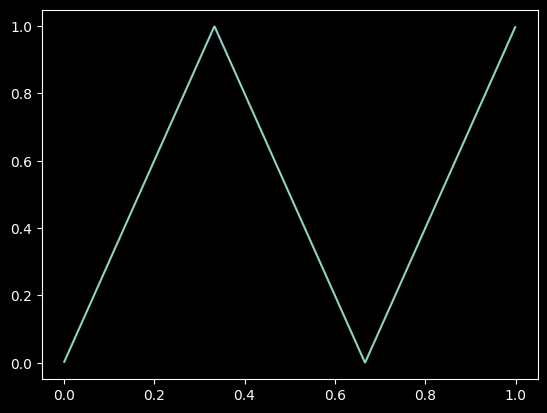

In [41]:
plt.plot(v, vmap(g)(v))

In [49]:
np.log(np.abs(vmap(grad(f))(v))).mean()

Array(0.6931473, dtype=float32)

In [56]:
vals, grads = vmap(value_and_grad(f))(v)

(array([778.,  36.,  24.,  20.,  18.,  16.,  16.,  18.,  22.,  52.]),
 array([1.88324410e-22, 3.98942307e-02, 7.97884613e-02, 1.19682685e-01,
        1.59576923e-01, 1.99471146e-01, 2.39365369e-01, 2.79259592e-01,
        3.19153845e-01, 3.59048069e-01, 3.98942292e-01]),
 <BarContainer object of 10 artists>)

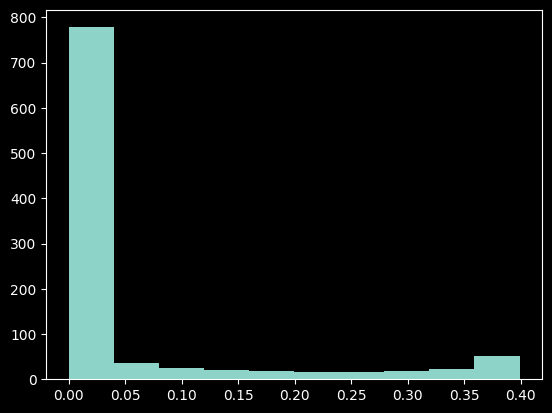

In [87]:
plt.hist(sp.stats.norm.pdf(10*np.abs(vals - vals[:, np.newaxis])[3, :]))

In [166]:
def empirical_cdf(v, g=100):
    s = np.sort(v)
    l = np.linspace(0,1,s.shape[0])
    def ecdf(x):
        w = sp.stats.norm.pdf(g*(x-s))
        return np.sum(l * w / np.sum(w))
    return ecdf

In [167]:
key = jax.random.PRNGKey(13012023)
ecdf = empirical_cdf(jax.random.normal(key, shape=(1000,)))

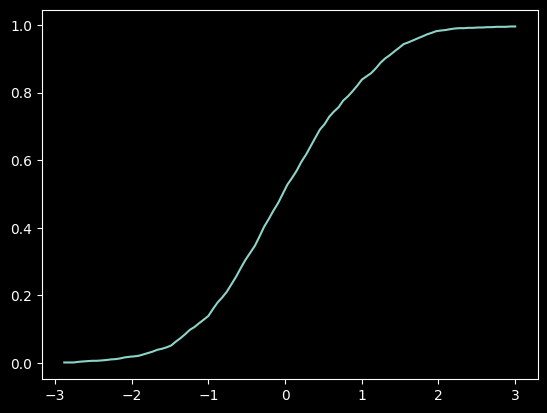

In [168]:
l = np.linspace(-3,3,100)
plt.plot(l, vmap(ecdf)(l))

In [244]:
def gcdf(f, us, g=100):
    gfs = np.abs(vmap(grad(f))(us))
    def temp(x):
        # w = sp.stats.norm.pdf(g*(x-us))
        w = sp.stats.uniform.pdf(g*(x-us), loc=-0.5, scale=1)
        return  #np.sum( (1 / gfs) * w / np.sum(w)) 
    return temp

In [245]:
us = jax.random.uniform(key, shape=(100000,))
fs = vmap(f)(us)
gs = vmap(g)(us)

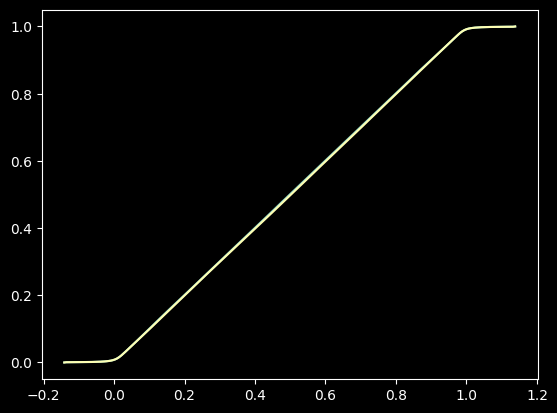

In [246]:
l = np.linspace(-3,3,1000)
plt.plot(l, vmap(empirical_cdf(fs))(l))
plt.plot(l, vmap(empirical_cdf(gs))(l))

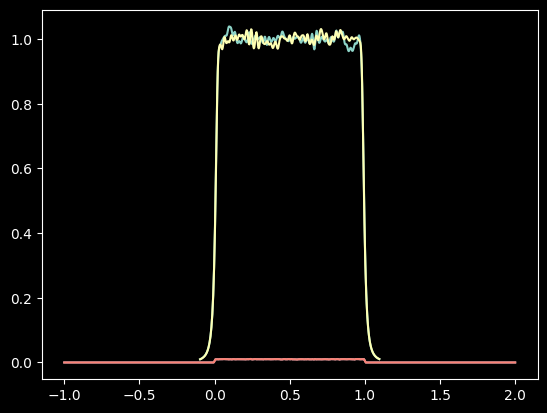

In [247]:
l = np.linspace(-1,2,1000)
plt.plot(l, vmap(grad(empirical_cdf(fs)))(l))
plt.plot(l, vmap(grad(empirical_cdf(gs)))(l))
plt.plot(l, vmap(gcdf(f, us))(l))
plt.plot(l, vmap(gcdf(g, us))(l))

In [90]:
w = sp.stats.norm.pdf(10*np.abs(vals - vals[:, np.newaxis]))

# Implementation of a Neural Network

In [299]:
def bforward(params, X):
    nn, U = params
    X = np.c_[X, U]
    for i, (W, b) in enumerate(nn):
        A = jax.nn.relu if i != len(nn)-1 else (lambda x: x)
        X = A(X @ W + b)
    return X

def init_nn(key, inout, last_af=lambda x: x):
    return [(jax.random.normal(key, shape=(inout[i], inout[i+1])),
             jax.random.normal(key, shape=(inout[i+1], ))) for i, key in enumerate(jax.random.split(key, len(inout)-1))]
        

In [548]:
keys = jax.random.split(jax.random.PRNGKey(15012023), 10)

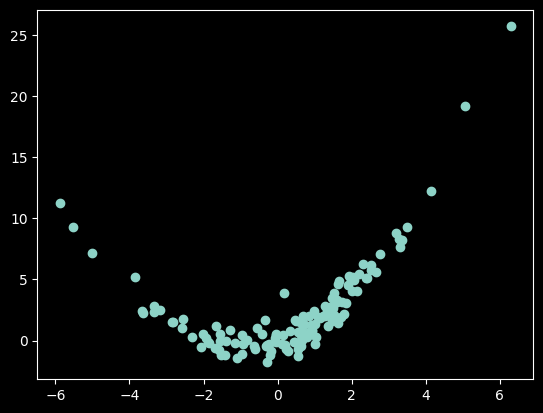

In [549]:
X = 2*jax.random.normal(keys[1], shape=(128,1))
Y = 0.5*X**2 + 1*X + 1*jax.random.normal(keys[2], shape=(128,1))
plt.scatter(X, Y)

$$-\mathbb{E}_{f \sim q}\text{log}p(Y | X, f) + \mathbb{H}[q(f|D), p(f)] - \mathbb{H}[q(f|D)] + C$$

In [552]:
def loss(nn, X, U, Y, prior, eps=0.0001):
    
    pred, (jacs,) = vmap(
        lambda u: value_and_jacrev(
            lambda u: bforward(
                (nn, u.reshape(1,-1).repeat(X.shape[0], axis=0)),
                X
            ).flatten(),
            u
        )
    )(U)
    
    log_prior = vmap(lambda x: np.log(prior(x) + eps))(pred)
    log_posterior = vmap(lambda J: np.log(np.abs(np.linalg.pinv(J)).sum(axis=1) + eps).sum())(jacs)

    
    H_pospri = -log_prior.mean()
    H_poster = -log_posterior.mean()
    
    logL = sp.stats.norm.logpdf(pred.T - Y).sum(axis=0).mean() # We suppose, that the standard deviation is equal to 1
    
    C = np.square(jax.nn.relu(-jacs)).sum(axis=(1,2)).mean()
    
    return -logL + H_pospri - H_poster + C
    
    

In [546]:
# loss(nn, X, U[:50], lambda x: np.exp(-x**2/2).mean())

In [617]:
key, subkey = jax.random.split(jax.random.PRNGKey(123123))
nn = init_nn(subkey, [16,64,64,1])
losses = []

In [618]:
opt_init, opt_update, get_params = optimizers.adam(0.01)
opt_state = opt_init(nn)

In [625]:
# loss = lambda params: np.square(bforward(params, X) - Y).sum()
n = 128
EPOCHS=500
for e in range(EPOCHS):
    key, subkey = jax.random.split(key)
    U = jax.random.uniform(subkey, shape=(32, 15))
    value, grads = value_and_grad(Partial(loss, X=X[:n, :], U=U, Y=Y[:n, :], prior=lambda x: sp.stats.norm.pdf(x, scale=50)))(get_params(opt_state))
    opt_state = opt_update(e, grads, opt_state)
    losses.append(value)
    print(f"\rloss: {value:03.03f}           ", end="")
print("\rDone.")

Done. 439.045           


Text(0.5, 1.0, '128')

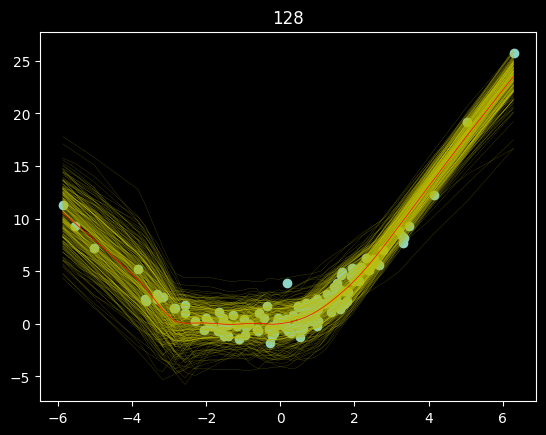

In [626]:
U = jax.random.uniform(subkey, shape=(300, 15))
results = vmap(lambda u: bforward((get_params(opt_state), u.reshape(1,-1).repeat(X.shape[0], axis=0)), X))(U)[:,:,0]
ind = np.argsort(X.flatten()[:128])
plt.scatter(X[ind], Y[ind])
for i in range(300):
    plt.plot(X[ind], results[i,:][ind], c='y', linewidth=0.1)
plt.plot(X[ind], results.mean(axis=0)[ind], c='r', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] + 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] - 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.title("128")

Text(0.5, 1.0, '64')

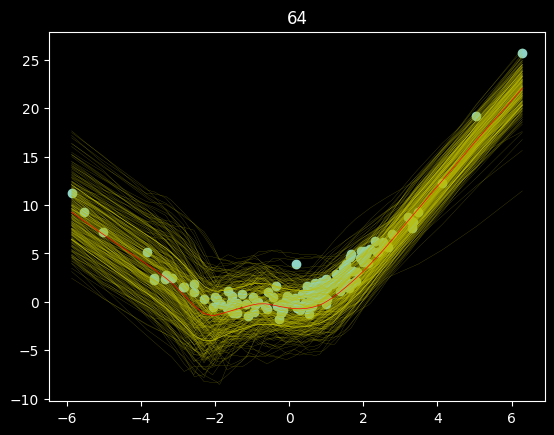

In [616]:
U = jax.random.uniform(subkey, shape=(300, 15))
results = vmap(lambda u: bforward((get_params(opt_state), u.reshape(1,-1).repeat(X.shape[0], axis=0)), X))(U)[:,:,0]
ind = np.argsort(X.flatten()[:128])
plt.scatter(X[ind], Y[ind])
for i in range(300):
    plt.plot(X[ind], results[i,:][ind], c='y', linewidth=0.1)
plt.plot(X[ind], results.mean(axis=0)[ind], c='r', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] + 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] - 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.title("64")

Text(0.5, 1.0, '32')

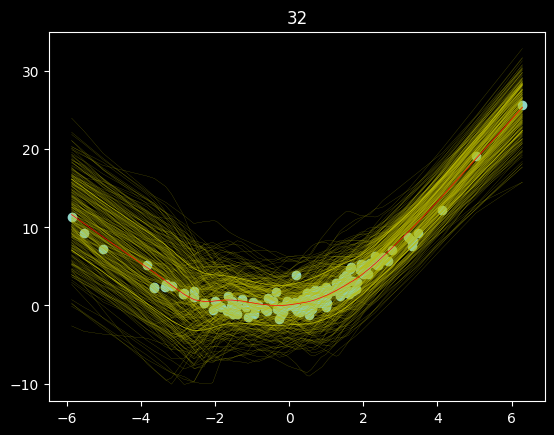

In [607]:
U = jax.random.uniform(subkey, shape=(300, 15))
results = vmap(lambda u: bforward((get_params(opt_state), u.reshape(1,-1).repeat(X.shape[0], axis=0)), X))(U)[:,:,0]
ind = np.argsort(X.flatten()[:128])
plt.scatter(X[ind], Y[ind])
for i in range(300):
    plt.plot(X[ind], results[i,:][ind], c='y', linewidth=0.1)
plt.plot(X[ind], results.mean(axis=0)[ind], c='r', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] + 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] - 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.title("32")

Text(0.5, 1.0, '16')

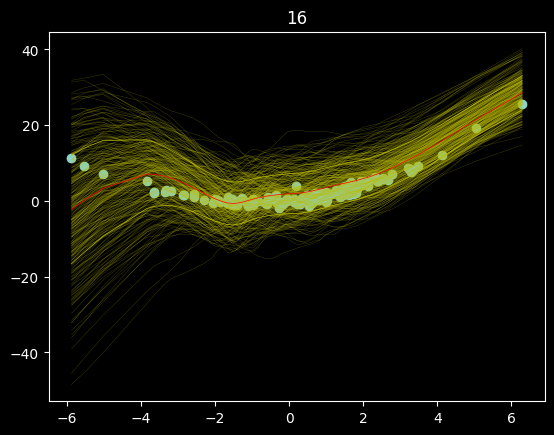

In [600]:
U = jax.random.uniform(subkey, shape=(300, 15))
results = vmap(lambda u: bforward((get_params(opt_state), u.reshape(1,-1).repeat(X.shape[0], axis=0)), X))(U)[:,:,0]
ind = np.argsort(X.flatten()[:128])
plt.scatter(X[ind], Y[ind])
for i in range(300):
    plt.plot(X[ind], results[i,:][ind], c='y', linewidth=0.1)
plt.plot(X[ind], results.mean(axis=0)[ind], c='r', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] + 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] - 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.title("16")

Text(0.5, 1.0, '8')

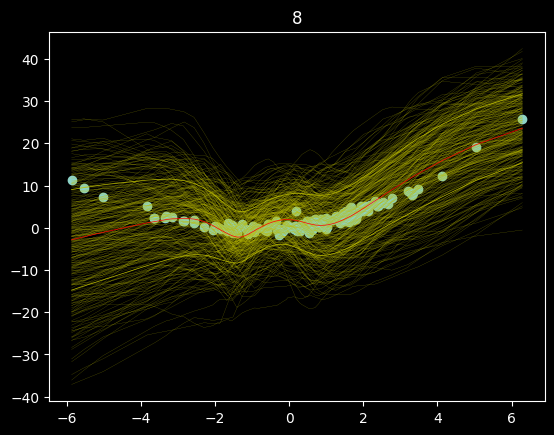

In [595]:
U = jax.random.uniform(subkey, shape=(300, 15))
results = vmap(lambda u: bforward((get_params(opt_state), u.reshape(1,-1).repeat(X.shape[0], axis=0)), X))(U)[:,:,0]
ind = np.argsort(X.flatten()[:128])
plt.scatter(X[ind], Y[ind])
for i in range(300):
    plt.plot(X[ind], results[i,:][ind], c='y', linewidth=0.1)
plt.plot(X[ind], results.mean(axis=0)[ind], c='r', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] + 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.plot(X[ind], results.mean(axis=0)[ind] - 1*results.std(axis=0)[ind], c='y', linewidth=0.5)
plt.title("8")

# Mononicity

In [ ]:
plt.plot(X[ind], bforward((get_params(opt_state), np.array([[.0,.0,.0]]).repeat(X[ind].shape[0], axis=0)), X[ind]), c='red')
plt.plot(X[ind], bforward((get_params(opt_state), np.array([[.0,.0,.2]]).repeat(X[ind].shape[0], axis=0)), X[ind]), c='orange')
plt.plot(X[ind], bforward((get_params(opt_state), np.array([[.0,.0,.4]]).repeat(X[ind].shape[0], axis=0)), X[ind]), c='yellow')
plt.plot(X[ind], bforward((get_params(opt_state), np.array([[.0,.0,.6]]).repeat(X[ind].shape[0], axis=0)), X[ind]), c='green')
plt.plot(X[ind], bforward((get_params(opt_state), np.array([[.0,.0,.8]]).repeat(X[ind].shape[0], axis=0)), X[ind]), c='blue')